In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
import tqdm
import numpy as np
import matplotlib.pyplot as plt

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

lambda_min = 0.5

In [13]:
class OneLayerNet(nn.Module):
    def __init__(self):
        super(OneLayerNet, self).__init__()
        self.fc1 = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
    def init_weights(self, w):
        self.fc1.weight.data = w
    
    def get_weight(self):
        return self.fc1.weight
    
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(2, 1, bias=False)
        self.fc2 = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    def init_weights(self, w1, w2):
        self.fc1.weight.data = w1
        self.fc2.weight.data = w2
    
    def get_weight(self):
        return self.fc1.weight, self.fc2.weight

In [14]:
class SGD(optim.Optimizer):
    def __init__(self, params, lr=0.1):
        defaults = dict(lr=lr)
        super(SGD, self).__init__(params, defaults)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                p.data.add_(grad, alpha=-group['lr'])
        return loss

class SquaredError(nn.Module):
    def __init__(self):
        super(SquaredError, self).__init__()
    
    def forward(self, y_pred, y):
        return 1/2*torch.sum((y_pred - y)**2)

class Trainer:
    def __init__(self, model, eta, optimizer=SGD, criterion=SquaredError):
        self.eta = eta

        self.model = model
        self.optimizer = optimizer(model.parameters(), lr=eta)
        self.criterion = criterion()

        self.weights = {
            'fc1.weight': [],
            'fc2.weight': [],
        }
        try:
            self.weights['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.detach()))
            self.weights['fc2.weight'].append(copy.deepcopy(self.model.fc2.weight.detach()))
        except:
            self.weights['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.detach()))

        self.gradients = {
            'fc1.weight': [],
            'fc2.weight': [],
        }
        self.error = []
        self.loss = []
        self.ntk = []
    
    def train_epoch(self, X, y):
        self.optimizer.zero_grad()
        y_pred = self.model(X)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss
    
    def train(self, X, y, epochs=100):
        y = y.view(-1, 1)

        for epoch in tqdm.trange(epochs):
            loss = self.train_epoch(X, y)
            self.loss.append(loss.item())

            error = y - self.model(X)
            self.error.append(error.detach())

            try:
                self.weights['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.detach()))
                self.weights['fc2.weight'].append(copy.deepcopy(self.model.fc2.weight.detach()))

                self.gradients['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.grad.detach()))
                self.gradients['fc2.weight'].append(copy.deepcopy(self.model.fc2.weight.grad.detach()))

                w1, w2 = self.model.get_weight()
                ntk = torch.tensor([[1-self.eta*(w1[0, 0]**2+w2[0, 0]**2), -self.eta*lambda_min*w1[0, 0]*w1[0, 1]], [-self.eta*lambda_min*w1[0, 0]*w1[0, 1], 1-self.eta*lambda_min**2*(w1[0, 1]**2+w2[0, 0]**2)]])
                self.ntk.append(ntk)
            except:
                self.weights['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.detach()))

                self.gradients['fc1.weight'].append(copy.deepcopy(self.model.fc1.weight.grad.detach()))

                w1 = self.model.get_weight()
                ntk = torch.tensor([[1-self.eta*(w1[0, 0]**2), 0], [0, 1-self.eta*lambda_min**2*w1[0, 1]**2]])
                self.ntk.append(ntk)

    def plot_loss(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(self.loss, color='blue')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        plt.show()

    def plot_error(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot([self.error[i][0, 0] for i in range(len(self.error))], color='blue', label='[0]')
        ax.plot([self.error[i][1, 0] for i in range(len(self.error))], color='red', label='[1]')

        ax.set_xlabel('epoch')
        ax.set_ylabel('error')
        ax.legend()
        plt.show()

    def plot_weight(self):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        w1 = self.weights['fc1.weight']
        axs[0].plot([w1[i][0, 0] for i in range(len(w1))], color='blue', label=r'$\theta_1$')
        axs[1].plot([w1[i][0, 1] for i in range(len(w1))], color='blue', label=r'$\theta_2$')

        w2 = self.weights['fc2.weight']
        axs[2].plot([w2[i][0, 0] for i in range(len(w2))], color='red', label=r'$\theta_3$')

        for ax in axs:
            ax.set_xlabel('epoch')
            ax.legend(loc='lower right')
        plt.show()

    def plot_ntk(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot([self.ntk[i][0, 0] for i in range(len(self.ntk))], color='blue', label='[0, 0]')
        ax.plot([self.ntk[i][1, 1] for i in range(len(self.ntk))], color='red', label='[1, 1]')

        ax.set_xlabel('epoch')
        ax.set_ylabel('ntk')
        ax.legend()
        plt.show()

In [15]:
class TrainPlots():

    def __init__(self, trainer1, trainer2):
        self.trainer1 = trainer1
        self.trainer2 = trainer2

    def plot_loss(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)

        ax.plot(self.trainer1.loss, label='1-layer', color='red', linestyle='--')
        ax.plot(self.trainer2.loss, label='2-layer', color='blue')

        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.legend()
        plt.show()

    def plot_error(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        error1 = self.trainer1.error
        error2 = self.trainer2.error

        axs[0].plot([error1[i][0, 0] for i in range(len(error1))], label='1-layer', color='red', linestyle='--')
        axs[0].plot([error2[i][0, 0] for i in range(len(error2))], label='2-layer', color='blue')
        axs[0].set_title(r'$x_1$')

        axs[1].plot([error1[i][1, 0] for i in range(len(error1))], label='1-layer', color='red', linestyle='--')
        axs[1].plot([error2[i][1, 0] for i in range(len(error2))], label='2-layer', color='blue')
        axs[1].set_title(r'$x_2$')
        
        for ax in axs:
            ax.set_xlabel('epochs')
            ax.set_ylabel('error')
            ax.legend()
    
        plt.show()

    def plot_weight(self):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        w1_1 = self.trainer1.weights['fc1.weight']
        w1_2 = self.trainer2.weights['fc1.weight']
        axs[0].plot([w1_1[i][0, 0] for i in range(len(w1_1))], color='red', linestyle='--', label='1-layer')
        axs[0].plot([w1_2[i][0, 0] for i in range(len(w1_2))], color='blue', label='2-layer')
        axs[0].set_title(r'$\theta_1$')

        axs[1].plot([w1_1[i][0, 1] for i in range(len(w1_1))], color='red', linestyle='--', label='1-layer')
        axs[1].plot([w1_2[i][0, 1] for i in range(len(w1_2))], color='blue', label='2-layer')
        axs[1].set_title(r'$\theta_2$')

        w2_2 = self.trainer2.weights['fc2.weight']
        axs[2].plot([w2_2[i][0, 0] for i in range(len(w2_2))], color='blue', label='2-layer')
        axs[2].set_title(r'$\theta_3$')

        for ax in axs:
            ax.set_xlabel('epochs')
            ax.legend(loc='lower right')
        plt.show()

    def plot_ntk(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot([self.trainer1.ntk[i][0, 0] for i in range(len(self.trainer1.ntk))], color='orange', linestyle='--', label='1-layer [0, 0]')
        ax.plot([self.trainer2.ntk[i][0, 0] for i in range(len(self.trainer2.ntk))], color='green', label='2-layer [0, 0]')
        ax.set_title(r'$[0, 0]$')

        ax.plot([self.trainer1.ntk[i][1, 1] for i in range(len(self.trainer1.ntk))], color='red', linestyle='--', label='1-layer [1, 1]')
        ax.plot([self.trainer2.ntk[i][1, 1] for i in range(len(self.trainer2.ntk))], color='blue', label='2-layer [1, 1]')
        ax.set_title(r'$[1, 1]$')

        ax.set_xlabel('epochs')
        ax.set_ylabel('ntk')
        ax.legend()
        plt.show()

    def plot_condition(self):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        ax.plot([torch.linalg.cond(self.trainer1.ntk[i]) for i in range(len(self.trainer1.ntk))], color='red', linestyle='--', label='1-layer')
        ax.plot([torch.linalg.cond(self.trainer2.ntk[i]) for i in range(len(self.trainer2.ntk))], color='blue', label='2-layer')

        ax.set_xlabel('epochs')
        ax.set_ylabel('condition number')
        ax.legend()
        plt.show()

In [47]:
class AlphaSearch():

    def __init__(self, alphas):
        self.alphas = alphas
        self.lambda_min = lambda_min
        self.eta = 2/(1+lambda_min)

        self.models_1l = dict([(alpha, OneLayerNet()) for alpha in alphas])
        for alpha in alphas:
            self.models_1l[alpha].init_weights(torch.tensor([[0, 0]], dtype=torch.float))

        self.models_2l = dict([(alpha, TwoLayerNet()) for alpha in alphas])
        for alpha in alphas:
            self.models_2l[alpha].init_weights(torch.tensor([[0, 0]], dtype=torch.float), torch.tensor([[1]], dtype=torch.float))

        self.trainers_1l = dict([(alpha, Trainer(self.models_1l[alpha], self.eta)) for alpha in alphas])
        self.trainers_2l = dict([(alpha, Trainer(self.models_2l[alpha], self.eta/2)) for alpha in alphas])

    def train(self, epochs=100):
        for alpha in tqdm.tqdm(self.alphas):
            X = torch.tensor([[1, 0], [0, lambda_min]], dtype=torch.float)
            y = torch.tensor([1, alpha*lambda_min], dtype=torch.float)

            self.trainers_1l[alpha].train(X, y, epochs=epochs)
            self.trainers_2l[alpha].train(X, y, epochs=epochs)

    def get_plotter(self, alpha):
        return TrainPlots(self.trainers_1l[alpha], self.trainers_2l[alpha])

In [45]:
alpha_search.models_2l[1].fc1.weight, alpha_search.models_2l[1].fc2.weight

(Parameter containing:
 tensor([[1.1648, 0.9841]], requires_grad=True),
 Parameter containing:
 tensor([[1.2955]], requires_grad=True))

100%|██████████| 10/10 [00:00<00:00, 63.14it/s]


0.0


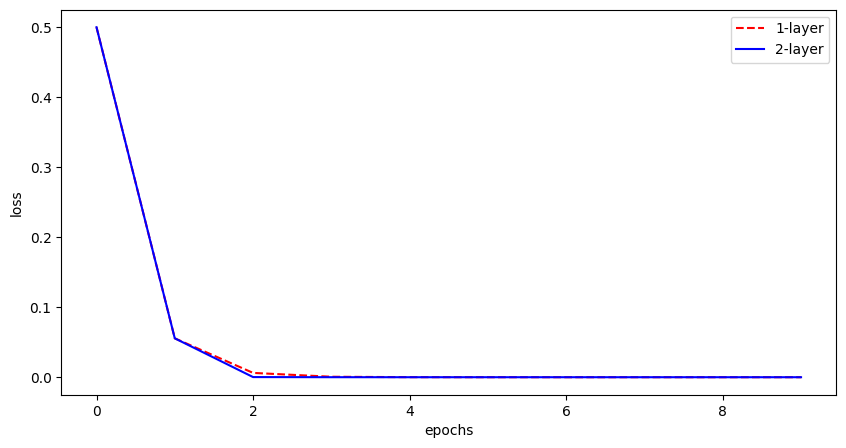

0.1111111111111111


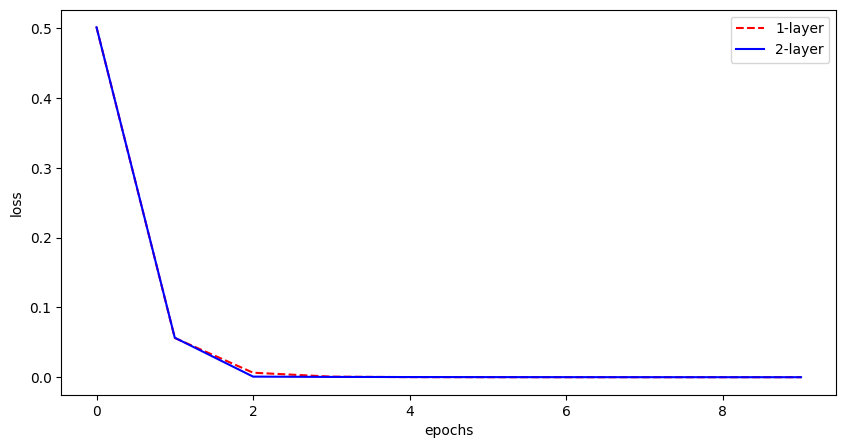

0.2222222222222222


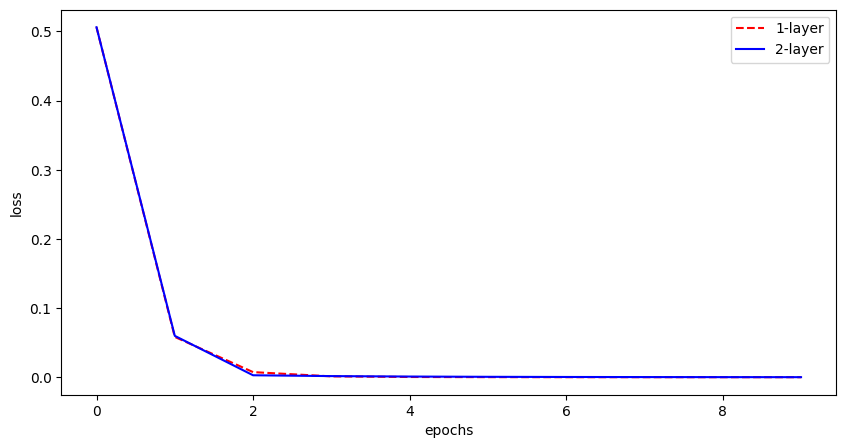

0.3333333333333333


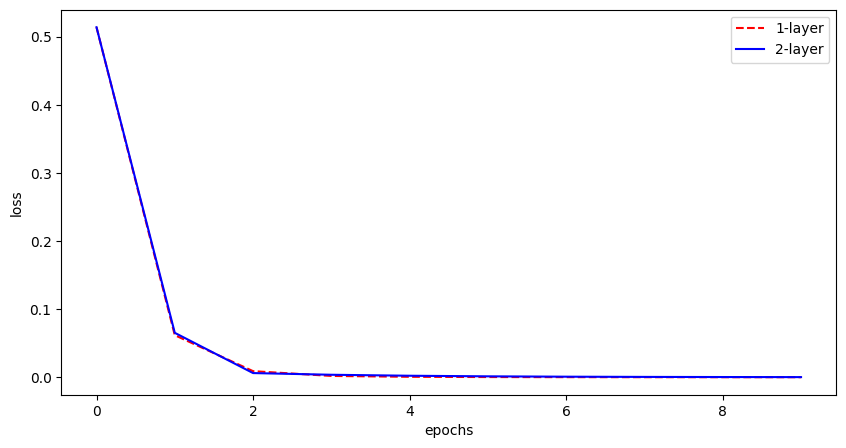

0.4444444444444444


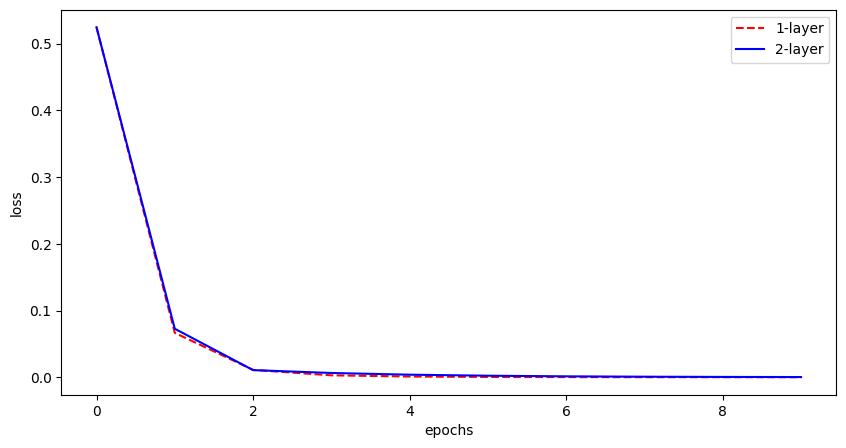

0.5555555555555556


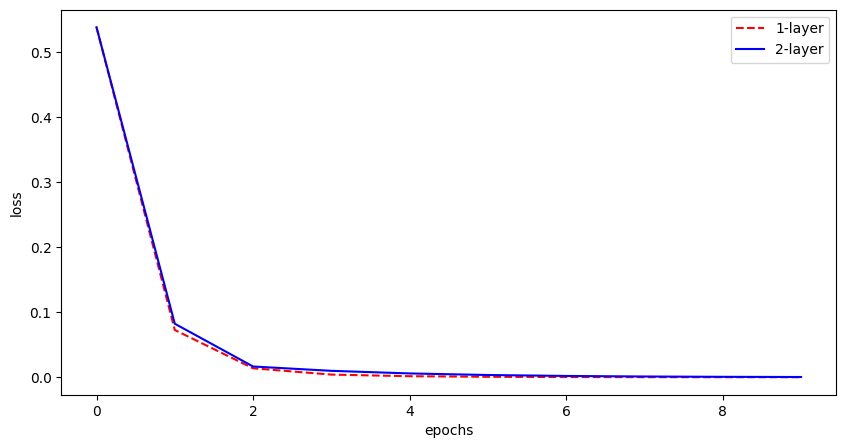

0.6666666666666666


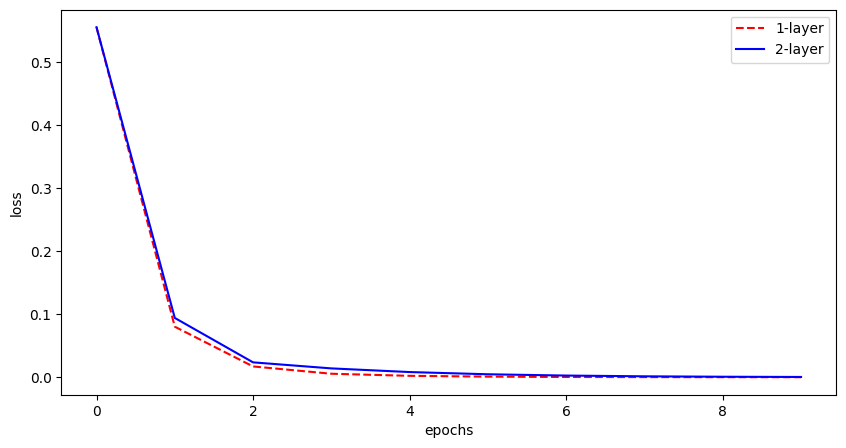

0.7777777777777777


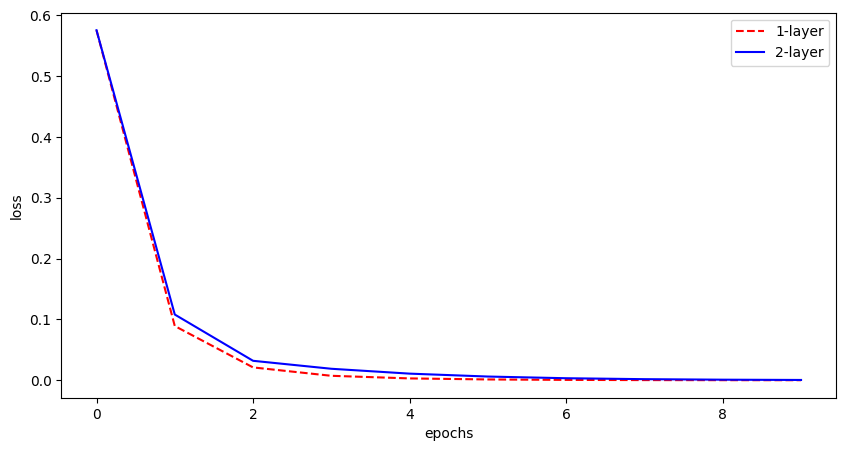

0.8888888888888888


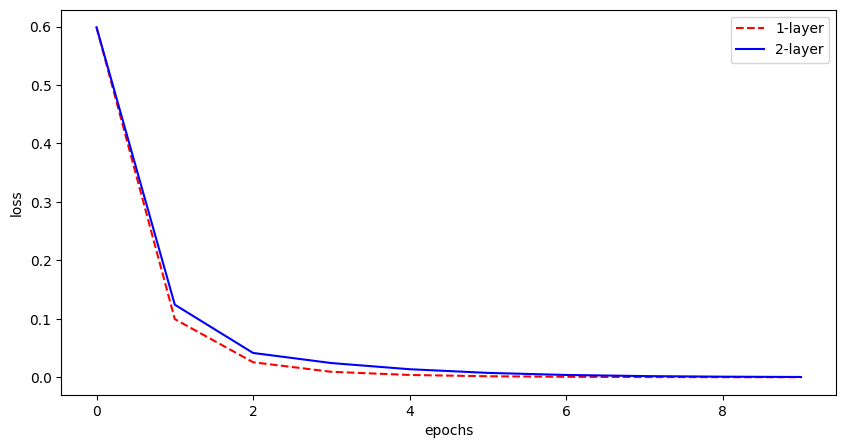

1.0


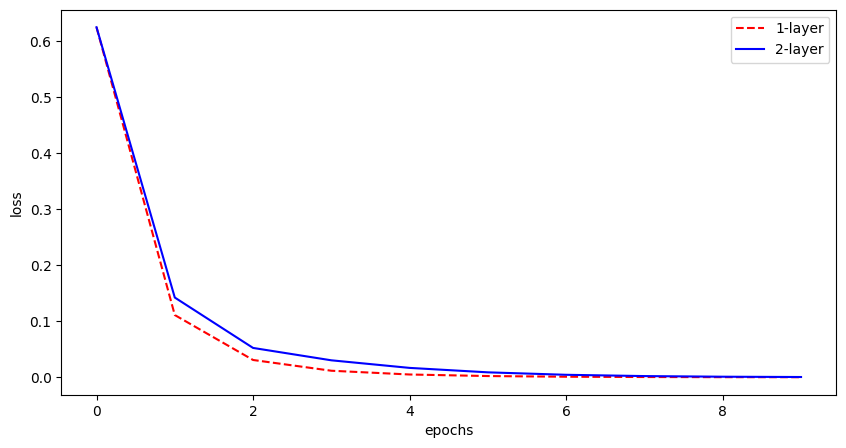

In [49]:
alphas = np.linspace(0, 1, 10)

alpha_search = AlphaSearch(alphas)
alpha_search.train(epochs=10)

for alpha in alphas:
    print(alpha)
    plotter = alpha_search.get_plotter(alpha)
    plotter.plot_loss()
    

Text(0.5, 1.0, '2-layer')

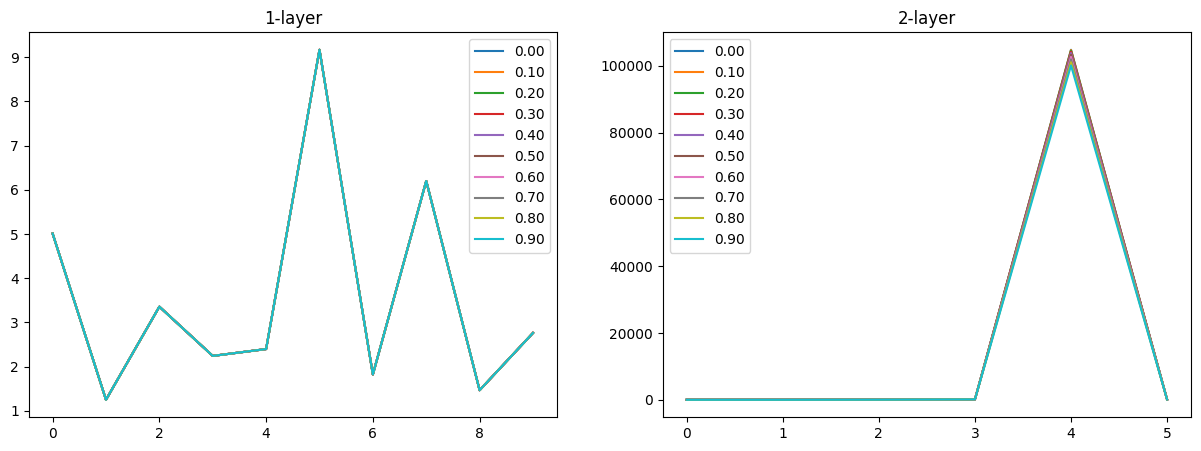

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for alpha in alphas:
    axs[0].plot([torch.linalg.cond(alpha_search.trainers_1l[alpha].ntk[i]) for i in range(len(alpha_search.trainers_1l[alpha].ntk))], label=f'{alpha.item():.2f}')
    axs[1].plot([torch.linalg.cond(alpha_search.trainers_2l[alpha].ntk[i]) for i in range(len(alpha_search.trainers_2l[alpha].ntk))], label=f'{alpha.item():.2f}')
    
    # axs[0].plot(alpha_search.trainers_1l[alpha].loss, label=f'{alpha.item():.2f}')
    # axs[1].plot(alpha_search.trainers_2l[alpha].loss, label=f'{alpha.item():.2f}')


axs[0].legend()
axs[1].legend()

axs[0].set_title('1-layer')
axs[1].set_title('2-layer')